# Introduction

This is the 2nd of two notebooks working with this dataset; the first one concerned data visualization and exploration. This one will concern building and testing simple machine learning models on the data to answer one primary question. The data contains many medical lab values related to liver function including 3 key ones that are often grouped together in something called Liver Function Tests (LFTs). These are Alkaline Phosphatase (ALP), Alanine Transferase (ALT), and Aspartate Aminotransferase (AsT). Normally, a fourth enzyme is called Gamma Glutamyl Transpeptidase (GGT) is also tested but GGT was not available in this dataset. LFTs also include Albumin and Bilirubin levels as standard; other measures are included as necessary.

In practice, elevations in LFTs may be referred to a mild, moderate, or marked elevations instead of their raw numerical value. The primary question I'm hoping to answer is whether the clinical categories (mild, moderate, marked) are any better or any worse than using the numerical values in predictive models.

## Notes on Data Processing and Flow of Notebook

I won't be spending much time on data processing or visualization as I've already done that. I won't be filtering out outliers as the second set of data I'll have for comparison will have all values converted to their clinical categories so there won't be any outliers. I will also not be explaining the initial data processing steps that I make in this notebook as that has also been accomplished in my earlier notebook.

# Libraries, Data, and Processing

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("indian_liver_patient.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [3]:
missing = data[data.Albumin_and_Globulin_Ratio.isna()]

for index, row in missing.iterrows():
    age, disease, gender = row["Age"], row["Dataset"], row["Gender"]
    new_table = data[(data["Age"] == age) & (data["Gender"] == gender) & (data["Dataset"] == disease)]
    print(age, disease, gender, new_table["Albumin_and_Globulin_Ratio"].mean())
    data.at[index, "Albumin_and_Globulin_Ratio"] =  new_table["Albumin_and_Globulin_Ratio"].mean()

45 1 Female 0.9
51 1 Male 0.89375
35 2 Female 1.8
27 2 Male 1.1025


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  583 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [5]:
data = data.rename(columns = {"Alkaline_Phosphotase": "ALP", "Alamine_Aminotransferase": "ALT", "Aspartate_Aminotransferase": "AST", "Total_Protiens":"Protein", "Albumin_and_Globulin_Ratio": "AGR", "Dataset": "Liver Patient"})

data["Liver Patient"].replace(2, 0, inplace = True)

In [6]:
data = pd.get_dummies(data, columns = ["Gender"]).drop(["Gender_Male"], axis = 1)

# Creating the 2nd Dataset

So the original data is prepped and ready to go, now to make the 2nd dataset where the numerical values are assigned to their clinical categories. For simplicity's sake, instead of using the actual words, numbers corresponding to the words will be used to code the data. For instance, below reference range is 0, within reference range is 1, mild elevation is 2, moderate elevation is 3, and marked elevation is 4. This is fine as the categories are most certainly ordinal and operations like marked > mild are completely valid.

For clarity a reference range is a range of values for a lab test that indicate normal or acceptable values for that test.

## Transformation Functions

In [7]:
def ref_range_transform(x, lower_bound, upper_bound):
    if x >= lower_bound and x <= upper_bound:
        return 1
    elif x > upper_bound:
        return x / upper_bound
    elif x < lower_bound:
        return x / lower_bound

def mild_mod_mark(x):
    if x < 1:
        return 0
    elif x == 1:
        return 1
    elif x > 1 and x < 2:
        return 2
    elif x >= 2 and x <= 5:
        return 3
    elif x > 5:
        return 4

The above functions do two things. ref_range_transform turns the raw numerical lab value into a multiple of it's reference range. mild_mod_mark maps the values from ref_range_transform to {0, 1, 2, 3, 4} based on criteria set out in the 23rd edition of Davidson's Principles and Practice of Medicine textbook.

In [9]:
clin_data = data.copy()

In [10]:
ref_ranges = {"Total_Bilirubin": (0.1, 1.2), "Direct_Bilirubin": (0, 0.29), "ALP": (44, 147), "ALT": (7, 56), "AST": (8, 40), "Protein": (6, 8), "Albumin": (3.5, 5)}

Units - Bilirubin (total and direct): mg/dL; AST and ALT: U/L; ALP IU/L; Protein and Albumin: g/dL

References ranges were taken from MedlinePlus, Medscape, and Pathology Harmony(UK)

## Applying the Transformations

In [11]:
for key in ref_ranges.keys():
    clin_data[key] = clin_data[key].apply(lambda x: ref_range_transform(x, lower_bound = ref_ranges[key][0], upper_bound = ref_ranges[key][1]))
    clin_data[key] = clin_data[key].apply(mild_mod_mark)

In [12]:
clin_data.head()

,Age,Total_Bilirubin,Direct_Bilirubin,ALP,ALT,AST,Protein,Albumin,AGR,Liver Patient,Gender_Female
0,65,1,1,2,1,1,1,0,0.90,1,1
1,62,4,4,3,2,3,1,0,0.74,1,0
2,62,4,4,3,2,2,1,0,0.89,1,0
3,58,1,2,2,1,1,1,0,1.00,1,0
4,72,3,4,2,1,2,1,0,0.40,1,0


## Countplots

Just taking a quick look at the distribution of the transformed data.

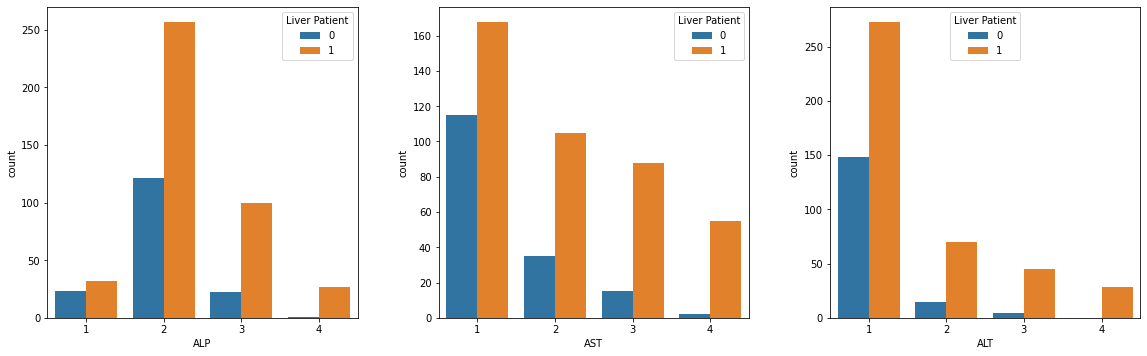

In [13]:
f, axes = plt.subplots(1, 3, figsize = (17, 6))
f.tight_layout(pad = 5)
sns.countplot(x = "ALP", hue = "Liver Patient", data = clin_data, ax = axes[0])
sns.countplot(x = "AST", hue = "Liver Patient", data = clin_data, ax = axes[1])
sns.countplot(x = "ALT", hue = "Liver Patient", data = clin_data, ax = axes[2])

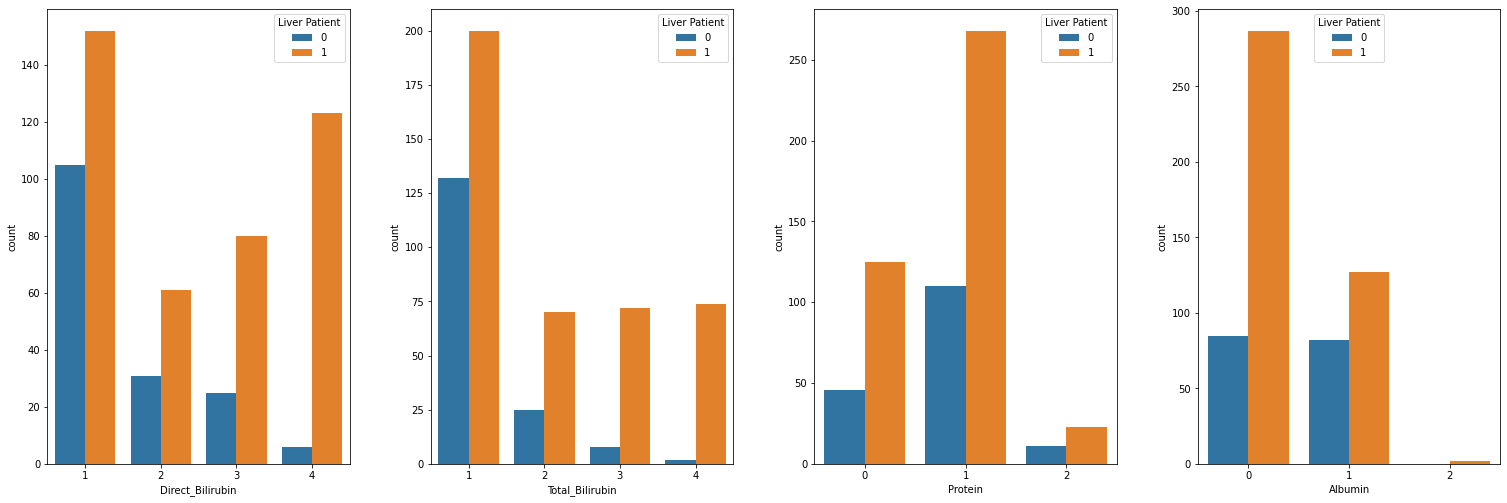

In [14]:
f, axes = plt.subplots(1, 4, figsize = (22, 8))
f.tight_layout(pad = 5)

sns.countplot(x = "Direct_Bilirubin", hue = "Liver Patient", data = clin_data, ax = axes[0])
sns.countplot(x = "Total_Bilirubin", hue = "Liver Patient", data = clin_data, ax = axes[1])
sns.countplot(x = "Protein", hue = "Liver Patient", data = clin_data, ax = axes[2])
sns.countplot(x = "Albumin", hue = "Liver Patient", data = clin_data, ax = axes[3])

Patients with liver disease clearly have much higher values across the board for LFTs as is to be expected. The one exception to this Albumin where liver patients tend to be below reference range values which is to be expected as Albumin is a plasma protein made by the liver. 

# Model Training and Evaluation

I'll be using Select From Model and two tree methods as well as Recursive Feature Elimination to try to extract the most important features for classification. To control, I'll use a modified dataset with Total_Bilirubin, and AGR dropped as both Bilirubin columns are highly correlated, and AGR isn't really necessary when you have Protein and Albumin levels.

This will result in a total of 4 dataframes being run through the 10-fold validation circuit to find a good model and the best fit. There will be 2 regular dataframes and 2 clinical categories dataframes. One from each will be the result of filtering via feature selection by Select From Model or RFE. The other will be the control dataframe. 

## Control Data

In [19]:
control_data, control_clin = data.copy(), clin_data.copy()

control_clin.drop(["Total_Bilirubin", "AGR"], axis = 1, inplace = True)
control_data.drop(["Total_Bilirubin", "AGR"], axis = 1, inplace = True)

control_x, control_y = control_data.drop(["Liver Patient"], axis = 1), control_data["Liver Patient"]
control_clin_x, control_clin_y  = control_clin.drop(["Liver Patient"], axis = 1), control_clin["Liver Patient"]

In [15]:
seed = 11

In [16]:
models = {"LSVC": LinearSVC(), "SVC": SVC(), "KNN": KNeighborsClassifier()}

The codeblock to try and find a model to focus on is highly repetitive, so creating a function will save me several lines of code.

In [17]:
def compare_models(models, X_data, y_data, n_fold, seed, score):
    for name, model in models.items():
        kfold = KFold(n_splits = n_fold, random_state = seed)
        cv_results = cross_val_score(model, X_data, y_data, cv = kfold, scoring = score)
        eval_msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
        print(eval_msg)

In [20]:
compare_models(models, control_x, control_y, 10, seed, "accuracy")

LSVC: 0.65645821157218 (0.10855893654308588)
SVC: 0.713354763296318 (0.05760447847723065)
KNN: 0.6514611338398597 (0.07664112059450633)


For the control non_clinical category data, the SVC seems to be the best baseline model. I'll tune its hyperparameters with GridSearch after I repeat the above process for the control clinical category data.

In [23]:
compare_models(models, control_clin_x, control_clin_y, 10, seed, "accuracy")

LSVC: 0.5805961426066628 (0.18105413093535494)
SVC: 0.7014903565166569 (0.06320605589056712)
KNN: 0.6857685563997662 (0.08642910370714872)


Again it appears a SVC is the best bet for the control clincal category data. 

### Hyperparameter Tuning for SVCs

In [24]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    kernels = ['rbf', 'linear']
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernels}
    grid_search = GridSearchCV(SVC(), param_grid, cv = nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [21]:
svc_param_selection(control_x, control_y, 10)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [22]:
svc_param_selection(control_clin_x, control_clin_y, 10)

C:\ProgramData\Anaconda3-1\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Seems the parameters are the same across both sets of data though that's not very surprising.

### Final Model Fitting and Evaluation for Control Data

Both have very similar accuracy scores but the clinical category data appears to result in less variation than the raw numerical data which is interesting. 

In [25]:
control_x_train, control_x_test, control_y_train, control_y_test = train_test_split(control_x, control_y, test_size = 0.3)
control_clin_x_train, control_clin_x_test, control_clin_y_train, control_clin_y_test  =train_test_split(control_clin_x, control_clin_y, test_size = 0.3)

In [26]:
svc = SVC(C = 10, kernel = 'rbf', gamma = 0.01)
svc.fit(control_x_train, control_y_train)

svc_clin = SVC(C = 10, kernel = 'rbf', gamma = 0.01)
svc_clin.fit(control_clin_x_train, control_clin_y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
report = classification_report(control_y_test, svc.predict(control_x_test), output_dict = True)
report_simple = {0: report["0"], 1: report["1"]}
pd.DataFrame(report_simple)

,0,1
precision,0.526316,0.769231
recall,0.217391,0.930233
f1-score,0.307692,0.842105
support,46.000000,129.000000


In [28]:
report_clin = classification_report(control_clin_y_test, svc_clin.predict(control_clin_x_test), output_dict = True)
report_simple_clin = {0: report_clin["0"], 1: report_clin["1"]}
pd.DataFrame(report_simple_clin)

,0,1
precision,0.571429,0.776398
recall,0.181818,0.954198
f1-score,0.275862,0.856164
support,44.000000,131.000000


Because the data is somewhat unbalanced, f1 is a better metric for model evaluation on single training. There is poor performance as well in both models for accurately identifying non-liver patients; likely due to the class imbalance. It seems both models are more or less even; there's not enough difference on a single sample to decide that one model is clearly better.

## Select From Model

In [29]:
sel_data, sel_clin = data.copy(), clin_data.copy()

sel_x, sel_y = sel_data.drop(["Liver Patient"], axis = 1), sel_data["Liver Patient"]
sel_clin_x, sel_clin_y  = sel_clin.drop(["Liver Patient"], axis = 1), sel_clin["Liver Patient"]

In [30]:
sel_x_train, sel_x_test, sel_y_train, sel_y_test = train_test_split(sel_x, sel_y, test_size = 0.3)
sel_clin_x_train, sel_clin_x_test, sel_clin_y_train, sel_clin_y_test  = train_test_split(sel_clin_x, sel_clin_y, test_size = 0.3)

In [31]:
selector = SelectFromModel(RandomForestClassifier(n_estimators =  100))
selector.fit(sel_x_train, sel_y_train)
new_sel_data = sel_x[sel_x.columns[selector.get_support()]]

In [32]:
selector = SelectFromModel(RandomForestClassifier(n_estimators =  100))
selector.fit(sel_clin_x_train, sel_clin_y_train)
new_clin_data = sel_clin_x[sel_clin_x.columns[selector.get_support()]]

In [33]:
for frame in [new_sel_data, new_clin_data]:
    print(frame.columns)

Index(['Age', 'Total_Bilirubin', 'ALP', 'ALT', 'AST'], dtype='object')
Index(['Age', 'AGR'], dtype='object')


Interestingly, the Random Forest Classifier found the clinical categories to not be useful in prediction. Let's see how these datasets fare in prediction.

In [34]:
sel_x = sel_x[new_sel_data.columns]
sel_clin_x = sel_clin_x[new_clin_data.columns]

In [35]:
compare_models(models, sel_x, sel_y, 10, seed, "accuracy")

LSVC: 0.6346873173582701 (0.14081700862106242)
SVC: 0.713354763296318 (0.05760447847723065)
KNN: 0.6497369959088253 (0.08051303021495942)


In [36]:
compare_models(models, sel_clin_x, sel_clin_y, 10, seed, "accuracy")


LSVC: 0.6323202805376973 (0.17006477154322372)
SVC: 0.6790181180596143 (0.06869731104332708)
KNN: 0.6841613091759206 (0.08203267076026056)


Looks like SVCs win out again with roughly the same accuracy.

## More Hyperparameter Tuning

In [ ]:
svc_param_selection(sel_x, sel_y, 10)

In [ ]:
svc_param_selection(sel_clin_x, sel_clin_y, 10)

## Final Fits and Assessment

In [37]:
sel_x_train, sel_x_test, sel_y_train, sel_y_test = train_test_split(sel_x, sel_y, test_size = 0.3)
sel_clin_x_train, sel_clin_x_test, sel_clin_y_train, sel_clin_y_test  = train_test_split(sel_clin_x, sel_clin_y, test_size = 0.3)

In [38]:
svc = SVC(C = 10, kernel = 'rbf', gamma = 0.01)
svc.fit(sel_x_train, sel_y_train)

svc_clin = SVC(C = 10, kernel = 'rbf', gamma = 0.01)
svc_clin.fit(sel_clin_x_train, sel_clin_y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
report = classification_report(sel_y_test, svc.predict(sel_x_test), output_dict = True)
report_simple = {0: report["0"], 1: report["1"]}
pd.DataFrame(report_simple)

,0,1
precision,0.521739,0.756579
recall,0.244898,0.912698
f1-score,0.333333,0.827338
support,49.000000,126.000000


In [40]:
report_clin = classification_report(sel_clin_y_test, svc_clin.predict(sel_clin_x_test), output_dict = True)
report_simple_clin = {0: report_clin["0"], 1: report_clin["1"]}
pd.DataFrame(report_simple_clin)

,0,1
precision,0.0,0.714286
recall,0.0,1.000000
f1-score,0.0,0.833333
support,50.0,125.000000


# Conclusions

It seems using SelectFromModel for feature selection with the raw data boosted the f1 score for correctly identifying those without liver disease though it still wasn't ideal. The f1 score of the model using the clinical categories however was abysmal when predicting those without liver disease. Even at its best, it would seem that transforming clinical lab values to clinical categories yields equivalent predictive value when compared to the raw data. At its worst, transforming to clinical categories horribly undermines predictive power.

There is reason for using clinical categories for communication between clinicians because it simplifies information exchanges without losing considerable detail but it appears it ought to stay there. It can tentatively be said that it offers no predictive advantage.